# Time series analysis of AT&T Trend data and Advertising Spend
In order to research what drives search trend for AT&T on Google, this notebook will contain various analyses, including time series analysis, an `fbprophet` analysis model, and a few Lasso regression models.  

Trend data was gathered from Google Trends API and advertising spend data were gathered from Ad$pender. The ad spend data is both weekly and monthly and the Google search trend data is daily, each through a period from 2014 to 2018.

### Importing packages and reading in data

In [312]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import date
from statsmodels.tsa import stattools 
from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools as stat
import numpy as np
import holidays
from datetime import date
from fbprophet import Prophet
import matplotlib.pyplot as pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import mean_absolute_error

Reading in the data. This data is Google Trend data aggregated from Google Trend API. The difference column is a simple difference from the previous period; in this case the previous day.

In [290]:
att = pd.read_csv('AT&T Time Series.csv', parse_dates = ['period'])
att.head(3)

,date,value,period,onediffvalue
0,Oct 07 2013,15743.703959,2013-10-07,NaN
1,Oct 08 2013,15678.278637,2013-10-08,-65.425322
2,Oct 09 2013,15329.779391,2013-10-09,-348.499246


### Data Distribution and Stationarity

To see the distribution of the data, we'll graph it using `matplotlib.pyplot`. It is clear from the graph that there is an extreme value near the end of 2014, and a general negative trend. In order to run a time series on our data, it must be stationary. This does not look stationary in the graph, and an adf of greater than 0.05 confirms this.

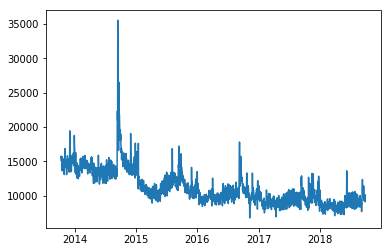

0.16865883185399788


In [291]:
# Graphing the non stationary data
x = att['period']
y = att['value']

plt.plot(x,y)
plt.show()

adf_result = stattools.adfuller(att['value']) 
print(adf_result[1]) # greater than 0.05 is stationary

Using a differenced value (the difference between the current period and the one before), we are able to make the data stationary which can be seen below.

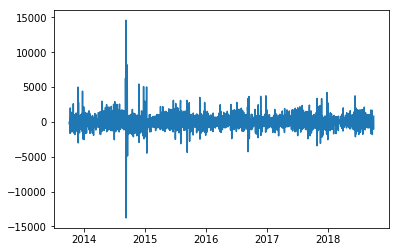

6.084722020825388e-21


In [292]:
x = att['period']
y = att['onediffvalue']
plt.plot(x,y)
plt.show()
adf_result = stattools.adfuller(att['onediffvalue'].iloc[1:]) # have to ignore the first 
print(adf_result[1])

Below is a sharper graph of the Google trend for AT&T.

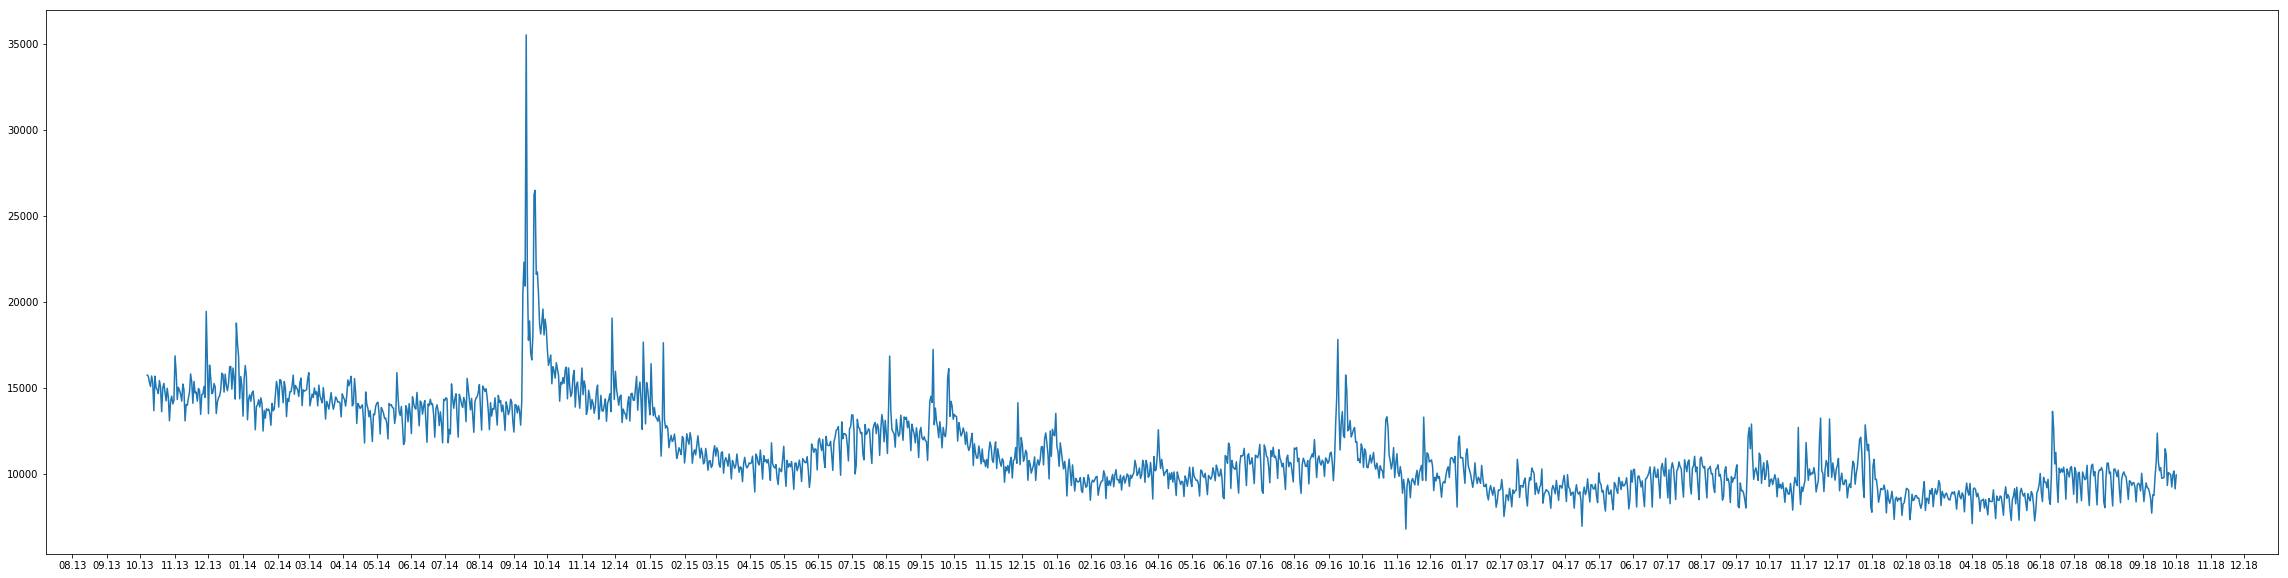

In [293]:
# Setting the index to time
att.set_index('period', inplace = True)

# Setting up a plot
dimensions = (40, 10)
# ax is the plot
fig, ax = plt.subplots(figsize = dimensions)

years = mdates.YearLocator()
months = mdates.MonthLocator()

yearmonth = mdates.DateFormatter('%m.%y')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)

ax.plot(att.index, att['value'])

### Trend, Seasonality, and Residuals

We are able to look at a variety of features in our data, including the actual trend value, average trend, seasonality and residuals below. As we can see, along with the massive spike in 2014, there are other things to note, including a very negative trend over the five-year period as well as very regular seasonality, usually peaking regularly near the end of the year, and fairly low residuals apart from the large spikes near the end of the year. 

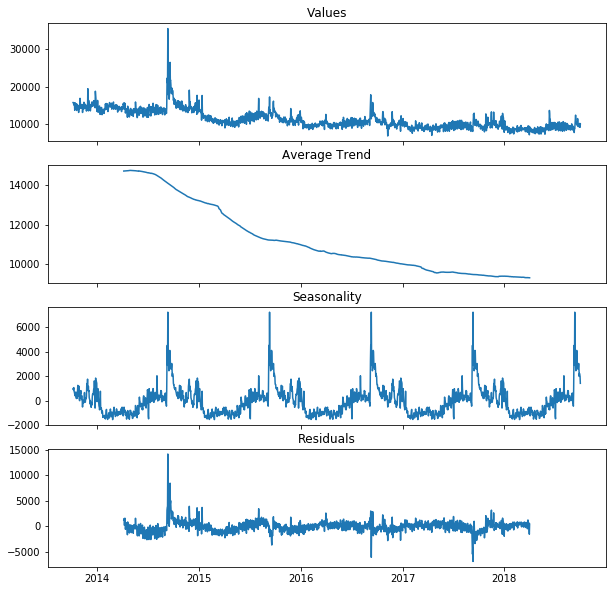

In [294]:
# Now looking at Seasonality
decompose_model = seasonal.seasonal_decompose(att['value'].tolist(), freq = 365)

dir(decompose_model)

dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = dimensions, sharex = 'all')

ax1.set_title("Values")
ax1.plot(att.index, att['value'])
ax2.set_title("Average Trend") 
ax2.plot(att.index, decompose_model.trend) # Negative trend
ax3.set_title("Seasonality")
ax3.plot(att.index, decompose_model.seasonal) # extremely seasonal
ax4.set_title("Residuals")
ax4.plot(att.index, decompose_model.resid)

### Side-by-side yearly seasonality

We can see the seasonality more clearly with a single year seasonality plot. This is the seasonality in Google trend for AT&T in 2014 and 2015, to see if there is any similarity. In it, we can see the high spike we saw earlier is in September for both years and each year is nearly identical. This is important to note for later when we try to uncover what caused this massive spike. 

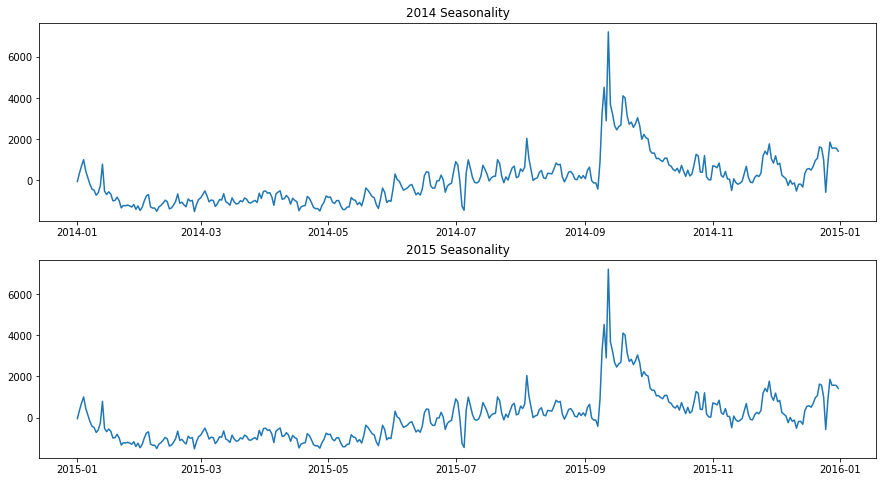

In [295]:
# Look into the seasonal data
att['seasonal'] = decompose_model.seasonal

startdate = pd.to_datetime('2014-01-01').date()
enddate = pd.to_datetime('2014-12-31').date()
oneyear14 = att.loc[startdate:enddate]

startdate = pd.to_datetime('2015-01-01').date()
enddate = pd.to_datetime('2015-12-31').date()
oneyear15 = att.loc[startdate:enddate]

# Graph just one year of seasonality
dimensions = (15,8)
fig, (ax1, ax2) = plt.subplots(2, figsize = dimensions)
ax1.set_title('2014 Seasonality')
ax1.plot(oneyear14.index, oneyear14.seasonal)
ax2.set_title('2015 Seasonality')
ax2.plot(oneyear15.index, oneyear15.seasonal)

### Adding Holidays to our time series analysis
Here, we will add holidays to our time series to see if we can better predict Google trend by inputting dates AT&T would know in advance, such as holidays and major phone releases. Because the major spikes are happening in September, I hypothesize that iPhone releases are causing a massive influx of searches for AT&T on Google. Presumably, AT&T would know the date of these launches ahead of time, so this is a valid input into our model.

Using a holidays package, we can get the common US holidays fairly easily and add them to a holiday data frame called `sales`. The idea here is that holidays allow consumers more time to go out and buy, as well as holidays often have sales attached to them.

In [296]:
goodholidays = []
for date, name in sorted(holidays.US(years = 2014).items()):
    print(date, name)
    goodholidays.append(name)

2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day


In [297]:
sales = pd.DataFrame(columns = ['holiday', 'ds', 'lower_window', 'upper_window'])

Here we'll add upper and lower windows to each US holiday depending on when they are. This is to account for some of the holidays where people might get a couple days off or the sales might go into the weekend.

In [298]:
for year in range(2014, 2021):
    for date, name in sorted(holidays.US(years = year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            day = date.weekday()
            if day == 0: # Monday
                lower_window = -2
            if day == 1: # Tuesday
                lower_window = -3
            if day == 3: # Thursday
                upper_window = 3
            if day == 4: # Friday
                upper_window = 2
                
            sales.loc[len(sales)] = [name, date, lower_window, upper_window] # Can add any "holiday" we want

Here I've manually added "holidays" for the iPhone pre-order date (PO) and the iPhone release date (REL). I've added two days to the lower and upper windows of each date to better account for a possible news cycle that might include iPhone release and pre-order information, possibly driving search trend related to that specific event. Additionally, I've added the dates of Super Bowls in our time frame that had confirmed AT&T Super Bowl ads that would indeed affect Google trend.

In [299]:
# Adding other holidays (using iphone pre-order dates)
sales.loc[len(sales)] = ['iPhone 6/6 Plus PO', '2014-09-12', -2, 2]
sales.loc[len(sales)] = ['iPhone 6/6 Plus REL', '2014-09-19', -2, 2]

sales.loc[len(sales)] = ['iPhone 6S/6S Plus PO', '2015-09-18', -2, 2]
sales.loc[len(sales)] = ['iPhone 6S/6S Plus REL', '2015-09-25', -2 , 2]

sales.loc[len(sales)] = ['iPhone SE', '2016-03-24', -2, 2]
sales.loc[len(sales)] = ['iPhone 7/7 Plus PO', '2016-09-09', -2, 2]
sales.loc[len(sales)] = ['iPhone 7/7 Plus REL', '2016-09-16', -2, 2]

sales.loc[len(sales)] = ['iPhone 8/8 Plus PO', '2017-09-15', -2, 2]
sales.loc[len(sales)] = ['iPhone 8/8 Plus REL', '2017-09-22', -2, 2]

sales.loc[len(sales)] = ['iPhone X PO', '2017-10-26', -2, 2]
sales.loc[len(sales)] = ['iPhone X REL', '2017-11-3', -2, 2]

sales.loc[len(sales)] = ['iPhone XS/XS Max PO', '2018-09-14', -2, 2]
sales.loc[len(sales)] = ['iPhone XS/XS Max REL', '2018-09-21', -2, 2]

sales.loc[len(sales)] = ['iPhone XR', '2018-10-19', -2, 2]
sales.loc[len(sales)] = ['Time Warner Merger', '2018-06-12', 0, 0]
sales.loc[len(sales)] = ['Super Bowl 50', '2016-02-07', 0, 1]
sales.loc[len(sales)] = ['Super Bowl XLVII', '2013-02-03', 0, 1]
sales.loc[len(sales)] = ['Super Bowl LI', '2017-02-05', 0, 1]

In [300]:
sales['ds']=pd.to_datetime(sales['ds'])
sales = sales.sort_values(by=['ds'], ascending=True)

### Creating a `fbprophet` model using the holidays specified
Looking at the full list of holidays. The observed holidays are holidays that have not happened, but will - to allow `fbprophet` to forecast future trend.

In [301]:
prophetdf = pd.DataFrame()
att['date'] = pd.to_datetime(att['date'])
prophetdf['ds'] = att['date']
prophetdf['y'] = att['value']

model = Prophet(holidays = sales, daily_seasonality = False)
model.add_country_holidays(country_name = 'US')

model.fit(prophetdf)
print(model.train_holiday_names)

0                Super Bowl XLVII
1                  New Year's Day
2     Martin Luther King, Jr. Day
3           Washington's Birthday
4                    Memorial Day
5                Independence Day
6                       Labor Day
7              iPhone 6/6 Plus PO
8             iPhone 6/6 Plus REL
9                    Columbus Day
10                   Veterans Day
11                   Thanksgiving
12                  Christmas Day
13           iPhone 6S/6S Plus PO
14          iPhone 6S/6S Plus REL
15                  Super Bowl 50
16                      iPhone SE
17             iPhone 7/7 Plus PO
18            iPhone 7/7 Plus REL
19                  Super Bowl LI
20             iPhone 8/8 Plus PO
21            iPhone 8/8 Plus REL
22                    iPhone X PO
23                   iPhone X REL
24             Time Warner Merger
25            iPhone XS/XS Max PO
26           iPhone XS/XS Max REL
27                      iPhone XR
28       Christmas Day (Observed)
29      New Ye

### Creating a forecast of Google Trend for AT&T
Using the Google trend data and the holidays, we can create a forecast of the next year of trend. As we can see from the chart below, we are capturing these high outliers, specifically in September, 2014 and various other outliers, especially compared to a model without holidays. From these charts, we can see that including holidays allows us to get a better fit in our time-series forecast. 

Additionally, on the `With Holidays` graph, we can see that the future prediction margin of error (dark blue) is much lower than it is for the `Without Holidays` graph, but the larger intervals are wider. This is most likely due to the `With Holidays` model being aware of outliers and attempting to predict them, but being more accurate with the general trend of data points.

#### With Holidays

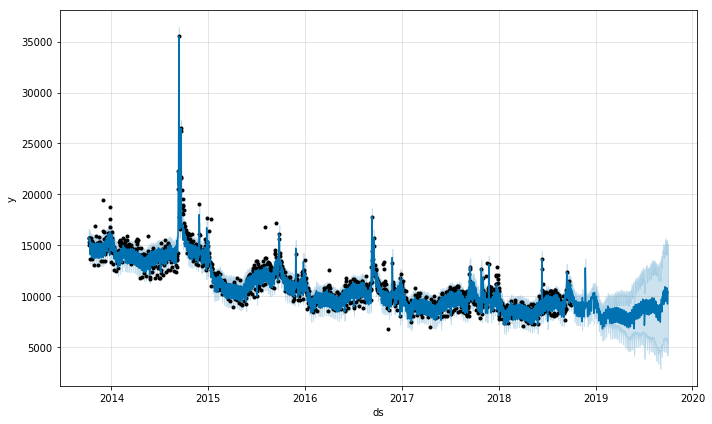

In [302]:
future = model.make_future_dataframe(periods = 365)
forecast = model.predict(future)
fig1 = model.plot(forecast)

#### Without Holidays

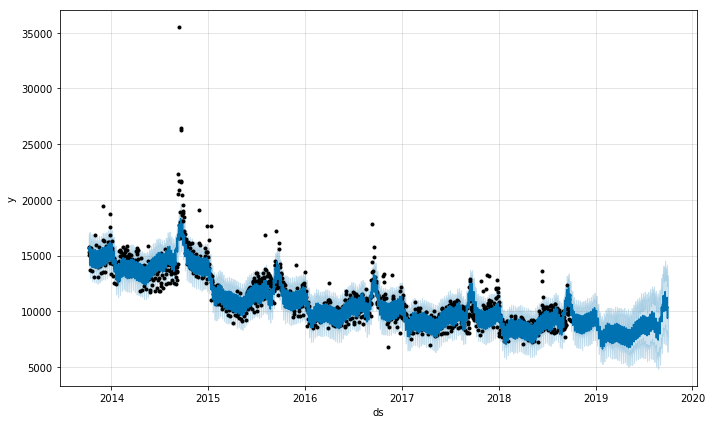

In [303]:
model2 = Prophet(daily_seasonality = False)
model2.fit(prophetdf)
future2 = model2.make_future_dataframe(periods = 365)
forecast2 = model2.predict(future2)
fig1 = model2.plot(forecast2)

### Plotting individual elements of the forecast
From the plots below, it would appear that our model is not incredibly confident about the future, however it is important to keep in mind the scale of the trend. Our model is again forecasting high trend in late September, and early October leading me to believe that search trend for AT&T is indeed driven by Apple product releases.

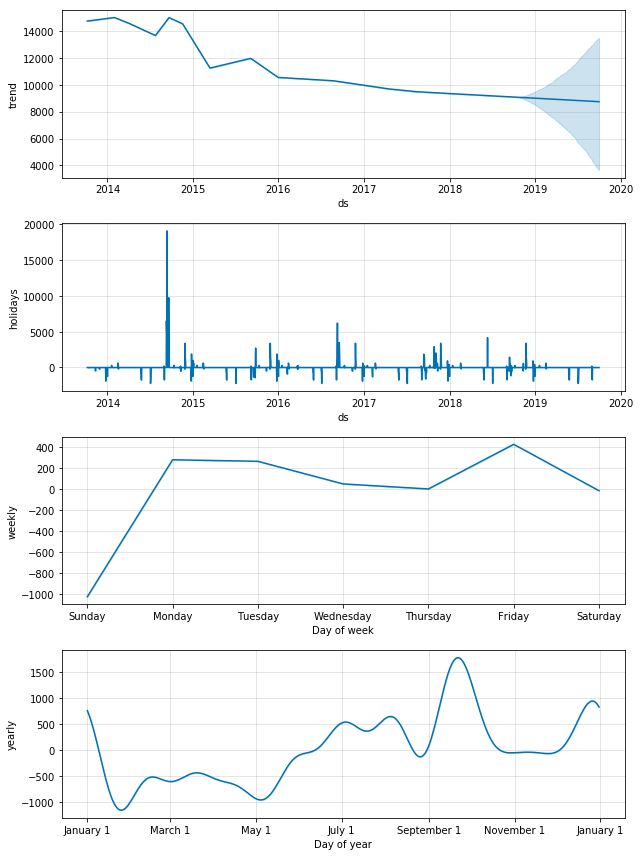

In [304]:
fig2 = model.plot_components(forecast)

### Analyzing the error rate in our forecast
As we can see, including holidays drastically reduces our mean absolute error, and improves the model.

In [305]:
erroranalysis = model.predict(prophetdf)
erroranalysis['value'] = list(prophetdf['y']) # it's introducing NaNs but the list solves this.
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

erroranalysis2 = model2.predict(prophetdf)
erroranalysis2['value'] = list(prophetdf['y']) # it's introducing NaNs but the list solves this.
erroranalysis2['residuals'] = erroranalysis2['value'] - erroranalysis2['yhat']
erroranalysis2['absoluteresiduals'] = abs(erroranalysis2['residuals'])

In [306]:
totalerror = sum(erroranalysis['absoluteresiduals'])
totalerror2 = sum(erroranalysis2['absoluteresiduals'])

print('With Holidays (MAE)', round(totalerror/len(erroranalysis), 4))
print('Without Holidays (MAE)', round(totalerror2/len(erroranalysis2), 4))

With Holidays (MAE) 438.2129
Without Holidays (MAE) 612.0652


#### Looking at dates with the largest error.
As we can see, comparing the errors with and without "holidays" included, the error rate decreases significantly and the individual outliers seem to be accounted for with these holiday calculations.

In [307]:
print('With Holidays\n', erroranalysis.nlargest(5, 'absoluteresiduals')[['ds', 'absoluteresiduals']])
print('\n')
print('Without Holidays\n', erroranalysis2.nlargest(5, 'absoluteresiduals')[['ds', 'absoluteresiduals']])

With Holidays
              ds  absoluteresiduals
463  2015-01-13        4770.288812
350  2014-09-22        4668.889362
337  2014-09-09        4635.678922
1112 2016-10-23        4221.222416
53   2013-11-29        4196.202110


Without Holidays
              ds  absoluteresiduals
340  2014-09-12       17747.339234
348  2014-09-20        8707.426780
347  2014-09-19        7929.526304
338  2014-09-10        5438.114434
1068 2016-09-09        5228.267760


## Using Ad$pender Data Instead of Holidays
Here we'll see if ad spend actually effects AT&T Google trend. First we'll read in the Ad data and connect it to the time period. To do this, we have to aggregate our AT&T trend data into week-to-week instead of day-to-day. 

In [308]:
adspender = pd.read_csv('att.adspend.csv')
adspender['TIME PERIOD'] = adspender['TIME PERIOD'].str.replace('WEEK OF ', '', regex = True)
adspender['TIME PERIOD'] = adspender['TIME PERIOD'].str.replace(' \(B\)', '', regex = True)
# Remove (000) from columns because it's in 1000s
adspender.columns = adspender.columns.str.replace(' DOLS \(000\)', '', regex = True)
adspender['FIXED_TIME'] = pd.to_datetime(adspender['TIME PERIOD'])
adspendnew = adspender.pivot_table(index = 'FIXED_TIME', aggfunc=np.sum)

# Closed = 'left' means monday is beginning of week, W means weekly
att_trendsweekly = att.resample('W-MON', closed = 'left', label = 'left').mean()
att_trendsweekly.head()

merged_weekly = adspendnew.join(att_trendsweekly)
merged_weekly.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,SYNDICATION,TOTAL,value,onediffvalue,seasonal
FIXED_TIME,,,,,,,,,,,,,,,
2013-10-07,4100.6,488.9,355.6,325.5,0.0,7328.0,13.3,0.0,3691.2,0.0,15.7,16318.8,15216.837520,-344.799666,860.560164
2013-10-14,4825.4,592.9,355.6,704.6,0.0,8579.1,68.2,0.0,3427.5,1243.7,0.0,19797.1,14908.216885,-8.371955,468.335374
2013-10-21,5079.5,201.5,355.6,711.0,0.0,12313.1,76.8,0.0,3700.8,693.1,0.0,23131.5,14537.070833,-75.274463,647.481756
2013-10-28,5298.3,2264.8,393.0,653.3,0.0,9943.2,12.5,4025.3,4303.9,693.1,15.7,27603.1,14882.617161,176.255145,490.485447
2013-11-04,4854.0,849.4,442.9,947.2,0.0,11132.6,7.0,0.0,4776.8,1062.8,0.0,24072.7,14564.268494,-177.590114,183.790934


### Plotting common types of Ad spend for AT&T as well as Total Ad Spend.
#### Breaking down ad spend by type
As we can see below, the bulk of our average weekly ad spend is Cable TV, Network TV, and Spot TV. These have been graphed below along with the total spend per week.

In [309]:
for column in list(merged_weekly):
    if column == 'TOTAL':
        print(column, '\t\t', '${:,.2f}'.format(np.mean(merged_weekly[column])*1000))
        break
    else:
        print(column, '\t', '${:,.2f}'.format(np.mean(merged_weekly[column])*1000))

CABLE TV 	 $4,631,552.11
MAGAZINES 	 $761,179.69
NAT SPOT RADIO 	 $756,538.70
NATL NEWSP 	 $505,234.87
NETWORK RADIO 	 $136,922.61
NETWORK TV 	 $5,937,105.75
NEWSPAPER 	 $306,396.17
OUTDOOR 	 $314,110.73
SPOT TV 	 $2,403,775.86
SUNDAY MAGS 	 $62,100.00
SYNDICATION 	 $46,822.99
TOTAL 		 $15,861,734.10


#### Plotting top 3 spend cateogries and total

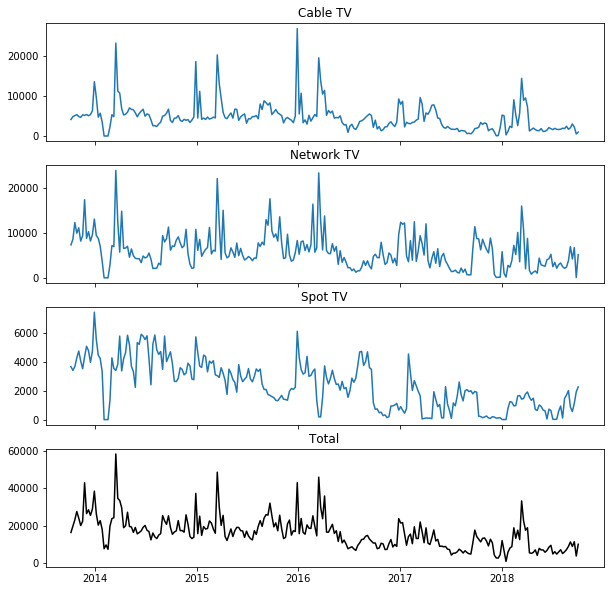

In [310]:
dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = dimensions, sharex='all')
ax1.set_title('Cable TV')
ax1.plot(adspendnew.index, adspendnew['CABLE TV'])
ax2.set_title('Network TV')
ax2.plot(adspendnew.index, adspendnew['NETWORK TV'])
ax3.set_title('Spot TV')
ax3.plot(adspendnew.index, adspendnew['SPOT TV'])
ax4.set_title('Total')
ax4.plot(adspendnew.index, adspendnew['TOTAL'], color = 'black')

#### AT&T Search Trend vs. Ad Spend

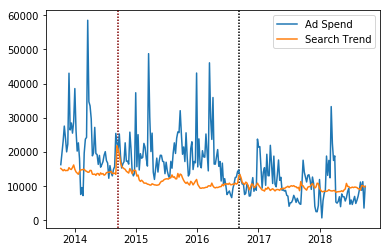

In [195]:
x = pd.to_datetime('2014-09-12')
x2 = pd.to_datetime('2016-09-09')
plt.axvline(x = x, color = 'maroon', dashes = (1,1))
plt.axvline(x = x2, color = 'black', dashes = (1,1))
ax1 = plt.plot(merged_weekly.index, merged_weekly['TOTAL'], label = 'Ad Spend')
ax2 = plt.plot(merged_weekly.index, merged_weekly['value'], label = 'Search Trend')
plt.legend(loc='upper right')
# Looks like the trend is the same, but not much correlation.

To see if our ad spend has any correlation with the Google trend data, I've graphed it above. As you can see, the trend of the spend is the same as the trend of the search (both negative), however there does not seem to be any real relationship between the two beyond as simple downward trend. I've added lines indicating the only two locations where the two seem to match up. 

The maroon line is Sept. 12th, 2014, the pre-order date of the iPhone 6 and 6 Plus, and the black line is Sept. 9th, 2016, the pre-order date of the iPhone 7 and 7 Plus. Once again, we can see that Google trend for AT&T seems to rely much more heavily on iPhone announcements and goings-on and even the only two points where spend seems to increase trend, the dates are related to iPhone pre-order dates anyways.

#### Making the data stationary
As we can see below, all the data is now stationary after using a differencing technique.

In [283]:
# Doing a differencing for all variables because so many are unstationary
ad_diff = pd.DataFrame()
for column in list(merged_weekly):
    colname = '%s_diff' % (column)
    # .diff(1) takes the difference from time 1 to 2, 2 to 3, etc
    ad_diff[colname] = merged_weekly[column].diff(1)
ct = 0
for column in list(ad_diff):
    adf_result = stat.adfuller(ad_diff[column][1:])
    if adf_result[1] > 0.05:
        print(column, adf_result[1])
        ct += 1
if ct == 0:
    print('All columns stationary')

All columns stationary


#### Correlation between types of Ad Spend, including value
Below, I've plotted a heat map of correlations between different types of ad spend and correlations with trend (`value`). This is using the merged ad spend-trend data set but I've made it stationary in order to better see actual outliers.

For the most part, different types of ad spend are uncorrelated with each other with a few exceptions:
* Network TV and cable TV exhibits highly positive correlation with total spend, suggesting this is where AT&T spends the most advertising money.
* Outdoor advertising is highly correlated with magazine advertisements.

Text(0.5, 1.0, 'Correlation Heatmap')

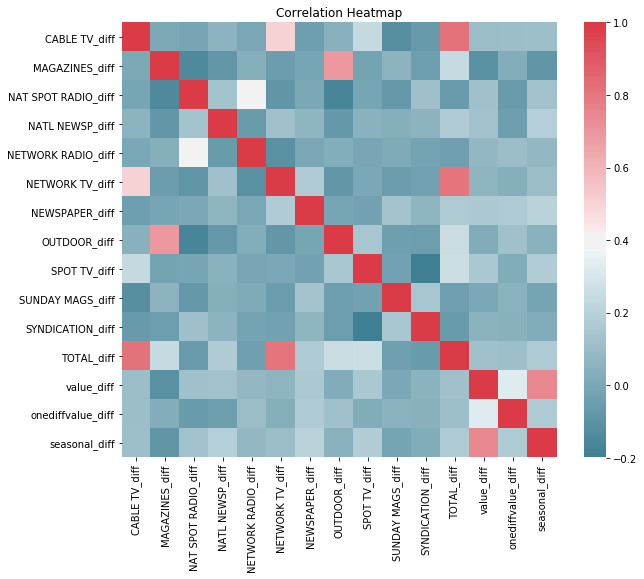

In [284]:
# Overall, ad spend has very little correlation with trends
f, ax = pyplot.subplots(figsize=(10,8))
corr = ad_diff.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
ax.set_title('Correlation Heatmap')

#### Testing lag
Because our ad spend data only contains physical media, we can expect there to be some level of lag between a consumer finally seeing the media to searching for it online. For example, a billboard might be up for four weeks, and though the spend is centered on the first week, a consumer might not see and search until the last week. 

To test for this lag, I've used a Granger Causality test to test the lag between ad spend and search trend.

In [259]:
# Using Granger Causality to test for lag
# Testing 8 weeks out...shouldn't have a ton of trend farther out from spend
numweeks = 8
signiflags = []
for column in list(ad_diff):
    if 'value' not in column:
        testframe = ad_diff[['value_diff', column]]
        testframe = testframe[1:]
        results = stat.grangercausalitytests(testframe, numweeks, verbose = False)
        for week in range(1, numweeks + 1):
            if results[week][0]['params_ftest'][1] < 0.05: # [0] is the ftest
                print(('%s is significant at %s weeks') % (column, week))
                signiflags.append(week)

MAGAZINES_diff is significant at 1 weeks
MAGAZINES_diff is significant at 4 weeks
MAGAZINES_diff is significant at 5 weeks
MAGAZINES_diff is significant at 6 weeks
MAGAZINES_diff is significant at 7 weeks
MAGAZINES_diff is significant at 8 weeks
NAT SPOT RADIO_diff is significant at 2 weeks
NAT SPOT RADIO_diff is significant at 3 weeks
NAT SPOT RADIO_diff is significant at 4 weeks
NAT SPOT RADIO_diff is significant at 5 weeks
NAT SPOT RADIO_diff is significant at 6 weeks
NAT SPOT RADIO_diff is significant at 7 weeks
NAT SPOT RADIO_diff is significant at 8 weeks
SPOT TV_diff is significant at 1 weeks


As we can see, the only two types of ad spend with statistically significant lag are magazine ads and national spot radio. These had little to no correlation with our values and when plotted together, they nearly seem unrelated.

One interesting thing to note, in the plot below we can see a regularity of magazine ads. This is most likely due to the seasonality of magazines in general - often monthly. Thus, the ad spend is seasonal as well. It appears as though AT&T stopped magazine ads about halfway through 2016, perhaps favoring more successful types of ad spend.

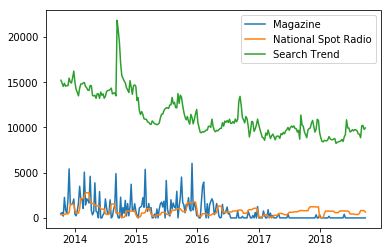

In [360]:
ax1 = plt.plot(merged_weekly.index, merged_weekly['MAGAZINES'], label = 'Magazine')
ax2 = plt.plot(merged_weekly.index, merged_weekly['NAT SPOT RADIO'], label = 'National Spot Radio')
ax3 = plt.plot(merged_weekly.index, merged_weekly['value'], label = 'Search Trend')
plt.legend(loc='upper right')

Regardless though, we'll calculate lag scores for these two advertising mediums and see if this helps us better predict search trend. In this case, I'm only going to calculate the first month of lag; two months of lag for variables that most likely have no impact on trend is a bit much.

In [261]:
# Adding 4 more weeks to the end of our data set
modelingset = ad_diff
date = pd.to_datetime('2018-10-08')
modelingset.loc[date] = np.nan
date = pd.to_datetime('2018-10-15')
modelingset.loc[date] = np.nan
date = pd.to_datetime('2018-10-22')
modelingset.loc[date] = np.nan
date = pd.to_datetime('2018-10-29')
modelingset.loc[date] = np.nan

In [262]:
lag_lst = ['MAGAZINES_diff', 'NAT SPOT RADIO_diff']
for item in lag_lst:
    for lag in range(1,5):
        colname = '%s_lag%s' % (item, lag)
        modelingset[colname] = modelingset[item].shift(lag)
modelingset.sort_index(axis = 1, inplace = True)


### Running a Lasso Model on our Ad Spend data
This model will allow us to compare errors between the lasso and the `fbprophet` model. Additionally, the lasso enables us to feature select and to see the most informative features for search trend for AT&T.

#### Creating a Lasso Model

In [363]:
alldata = modelingset.drop(columns = ['onediffvalue_diff', 'seasonal_diff'], axis = 1)
allpredictors = []
for var in list(alldata):
    if "value" not in var:
        allpredictors.append(var)
alldata = alldata.iloc[5:] # Getting rid of nulls introduced by lag
alldata = alldata.iloc[:-4]

In [364]:
predictors = alldata[allpredictors]
target = alldata['value_diff']

pred_train, pred_test, target_train, target_test = train_test_split(predictors, target, test_size = 0.3, random_state = 22)
modellasso = LassoLarsCV(cv = 10, precompute=False)
modellasso = modellasso.fit(pred_train.values, target_train.values)

predictors_model = pd.DataFrame(allpredictors)
predictors_model.columns = ['label']
predictors_model['coeff'] = modellasso.coef_

#### Evaluating predictiveness
As we can see below, the code is working, however there are no features with coefficients high enough for the Lasso model to suggest as important. This suggests that ad spend is highly unpredictive for this model. Though our mean absolute error seems within the realm of the fbprophet model, the differences between the training and test r-squared as well as the fact that the test r-squared is negative suggests that this is a highly unstable model. 

I believe that this model is unpredictive for Google search trend because AT&T in a consumer's mind is perhaps little more than a utility. This would explain why the search trend matches so accurately to Apple events - consumers only search for AT&T when they want to get the latest phone or gadget, not necessarily because they want to know about AT&T.

In [365]:
for index, row in predictors_model.iterrows():
    if row['coeff'] > 0:
        print(row.values)

In [367]:
test_error = mean_absolute_error(target_test, modellasso.predict(pred_test))
print('Lasso MAE', test_error)
print('Fbprophet MAE', np.mean(erroranalysis['absoluteresiduals']), '\n')

rsquared_train = modellasso.score(pred_train, target_train)
print('Lasso Training R-Square', rsquared_train)

rsquared_test = modellasso.score(pred_test, target_test)
print('Lasso Test R-Square', rsquared_test)

Lasso MAE 485.1708466967185
Fbprophet MAE 438.21289441497703 

Lasso Training R-Square 0.0
Lasso Test R-Square -9.939388261548388e-06


### Trying the same process but with Apple Ad Spend and AT&T search trend
Here I've tried the same technique, except I've used Apple ad spend instead of AT&T ad spend. Unfortunately, I wasn't able to get weekly data with my license so the Apple ad spend data is monthly, starting from 2014. 

In [345]:
apple = pd.read_csv('apple_monthly.csv', parse_dates = True)

#### Cleaning the data set and merging trend and spend

In [346]:
apple.columns = apple.columns.str.replace(' DOLS \(000\)', '', regex = True)
apple.columns = apple.columns.str.replace('Sum of ', '', regex = True)
apple.columns = apple.columns.str.replace('Row Labels', 'period', regex = True)
apple['period'] = pd.to_datetime(apple['period'])

apple = apple.fillna(0)
apple = apple[:len(apple)-3]
apple.set_index('period', inplace = True)
att_trendsmonthly = att.resample('MS', closed = 'left', label = 'left').mean()
att_trendsmonthly = att_trendsmonthly[12:]

In [347]:
merged_monthly = apple.join(att_trendsmonthly)
merged_monthly.head()

,NETWORK TV,CABLE TV,SYNDICATION,SPOT TV,MAGAZINES,SUNDAY MAGS,NATL NEWSP,NEWSPAPER,NETWORK RADIO,OUTDOOR,NAT SPOT RADIO,TOTAL,value,onediffvalue,seasonal
period,,,,,,,,,,,,,,,
2014-10-01,58531.2,8510.0,0.0,48.2,10075.5,260.1,870.5,163.1,0.0,7765.9,0.0,86224.5,15497.633844,-112.414281,758.033252
2014-11-01,45418.4,7052.9,160.3,20.1,10338.8,214.2,233.1,200.5,0.0,5680.1,0.0,69318.4,14461.346847,-20.822287,408.834535
2014-12-01,59640.7,12099.1,0.0,345.3,3717.6,0.0,0.0,8.1,0.0,7068.8,0.0,82879.6,14409.452791,-6.279774,600.946294
2015-01-01,41561.2,7102.1,0.0,0.8,3518.1,0.0,0.0,0.0,0.0,3780.9,0.0,55963.1,12698.195420,-66.469100,-593.027835
2015-02-01,11493.8,468.6,0.0,0.1,962.2,0.0,99.6,0.0,0.0,4433.3,0.0,17457.6,11250.631109,-15.276681,-1131.894115


#### Plotting normalized trend and ad spend together
I've normalized the ad spend and trend because Apple ad spend is vastly higher in pure numerical value than AT&T search trend. I would argue that the graph below is very inconclusive and shows really no relationship between Apple ad spend and AT&T search trend.

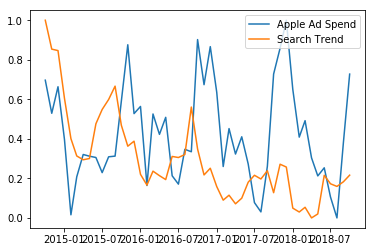

In [361]:
# First going to normalize the total and values together
merged_monthly['norm_total'] = (merged_monthly['TOTAL'] - min(merged_monthly['TOTAL']))/(max(merged_monthly['TOTAL'])-min(merged_monthly['TOTAL']))
merged_monthly['norm_value'] = (merged_monthly['value'] - min(merged_monthly['value']))/(max(merged_monthly['value'])-min(merged_monthly['value']))

ax1 = plt.plot(merged_monthly.index, merged_monthly['norm_total'], label = 'Apple Ad Spend')
ax2 = plt.plot(merged_monthly.index, merged_monthly['norm_value'], label = 'Search Trend')
plt.legend(loc='upper right')

#### Looking at a correlation heatmap between AT&T search trend and Apple Ad Spend
Once again, network TV and cable TV are the highest categories for spend. Unfortunately, there seems to be no correlation between search trend and any advertising spend.

NETWORK RADIO_diff 0.11940709228756297


Text(0.5, 1.0, 'Correlation Heatmap')

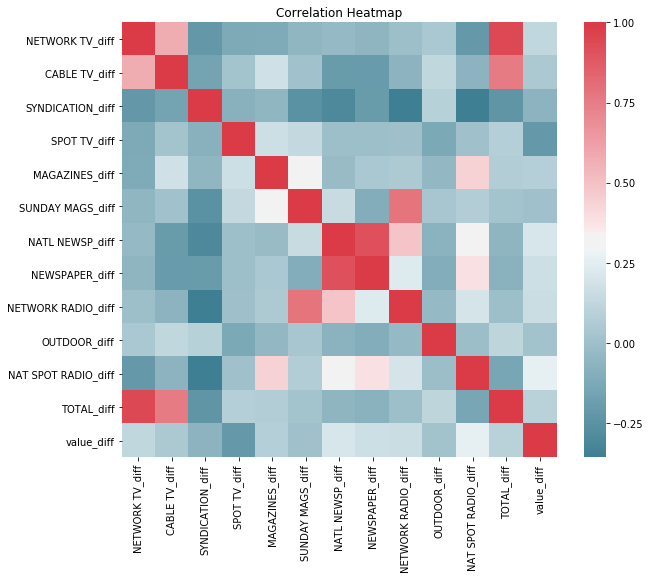

In [375]:
ad_diff_month = pd.DataFrame()
for column in list(merged_monthly):
    colname = '%s_diff' % (column)
    # .diff(1) takes the difference from time 1 to 2, 2 to 3, etc
    ad_diff_month[colname] = merged_monthly[column].diff(1)
ct = 0
for column in list(ad_diff_month):
    adf_result = stat.adfuller(ad_diff_month[column][1:])
    if adf_result[1] > 0.05:
        print(column, adf_result[1])
        ct += 1
if ct == 0:
    print('All columns stationary')
ad_diff_month.drop(columns = ['norm_total_diff', 'norm_value_diff','seasonal_diff', 'onediffvalue_diff'] , axis=1, inplace=True)

f, ax = pyplot.subplots(figsize=(10,8))
corr = ad_diff_month.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
ax.set_title('Correlation Heatmap')

#### Creating a Lasso model to predict AT&T search trend using Apple ad spend

As we can see below, this model actually does theoretically worse than our AT&T ad spend Lasso model, with a higher mean absolute error. In effect though, both models are not predictive at all and it would appear that advertising spend is not a good way to predict search trend for AT&T. Once again, there are no coefficients in the model with any predictive power.

In [372]:
allpredictors = []
alldata = ad_diff_month[1:]
for var in list(alldata):
    if "value" not in var:
        allpredictors.append(var)

predictors = alldata[allpredictors]
target = alldata['value_diff']

pred_train, pred_test, target_train, target_test = train_test_split(predictors, target, test_size = 0.3, random_state = 22)
modellasso = LassoLarsCV(cv = 10, precompute=False)
modellasso = modellasso.fit(pred_train.values, target_train.values)

predictors_model = pd.DataFrame(allpredictors)
predictors_model.columns = ['label']
predictors_model['coeff'] = modellasso.coef_

for index, row in predictors_model.iterrows():
    if row['coeff'] > 0:
        print(row.values)
        
test_error = mean_absolute_error(target_test, modellasso.predict(pred_test))
print('Lasso MAE', test_error)
print('Fbprophet MAE', np.mean(erroranalysis['absoluteresiduals']), '\n')

rsquared_train = modellasso.score(pred_train, target_train)
print('Lasso Training R-Square', rsquared_train)

rsquared_test = modellasso.score(pred_test, target_test)
print('Lasso Test R-Square', rsquared_test)

Lasso MAE 536.2245558264608
Fbprophet MAE 438.21289441497703 

Lasso Training R-Square 0.0
Lasso Test R-Square -0.12024745483822463


### Conclusions
It's clear that our `fbprophet` model is much better at forecasting AT&T search trend on Google. Additionally, I believe it is possible to say that Apple product releases (and major phone releases in general) are the real predictor of AT&T search trend. This is possibly due to the fact that perhaps consumers think of AT&T simply as a utility from which to get the latest gadget. Regardless, this is displayed in a time series forecast of trend data where I've added black lines for every iPhone pre-order date.

Below, I've graphed the finished `fbprophet` model with black lines at major iPhone pre-release days. As one can see, they line up perfectly with spikes in the general trend data.

This model is a very good model for forecasting search trend for AT&T as well as aligning with past search trend spikes and dips.

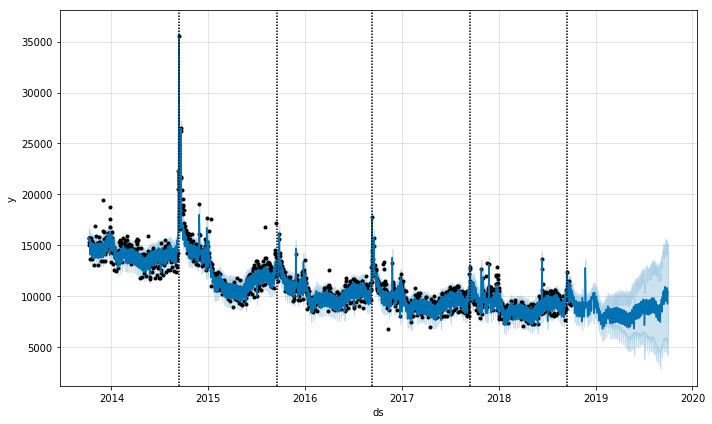

In [374]:
fig1 = model.plot(forecast)
plt.axvline(x = pd.to_datetime('2014-09-12'), color = 'black', dashes = (1,1))
plt.axvline(x = pd.to_datetime('2015-09-18'), color = 'black', dashes = (1,1))
plt.axvline(x = pd.to_datetime('2016-09-09'), color = 'black', dashes = (1,1))
plt.axvline(x = pd.to_datetime('2017-09-15'), color = 'black', dashes = (1,1))
plt.axvline(x = pd.to_datetime('2018-09-14'), color = 'black', dashes = (1,1))